In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [50]:
train_df = pd.read_csv('dataset/Train.csv')
test_df = pd.read_csv("dataset/Test.csv")

In [6]:
train_df.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


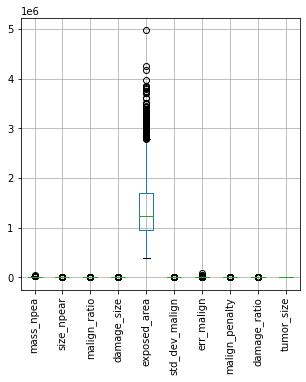

In [8]:
train_df.boxplot(figsize=(5,5),rot=90)

In [13]:
train_df.shape

(9146, 10)

In [51]:
q1 = train_df.quantile(0.25)
q3 = train_df.quantile(0.75)

iqr = q3-q1

In [52]:
train_red = train_df[~((train_df<q1-1.5*iqr)|(train_df>q3+1.5*iqr)).any(axis=1)]

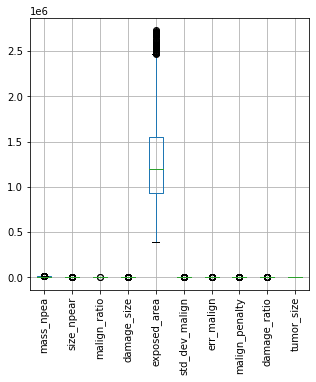

In [11]:
train_red.boxplot(figsize=(5,5),rot=90)

In [12]:
train_red.shape

(8329, 10)

In [160]:
x = train_df.drop(columns=['tumor_size'])
y = train_df['tumor_size'].values

In [161]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler

In [162]:
rs = RobustScaler()
mm = MinMaxScaler()

x = rs.fit_transform(x)
y = mm.fit_transform(y.reshape(-1,1))

In [163]:
from sklearn.model_selection import train_test_split

In [164]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.15,random_state=42)

In [165]:
x_test = rs.transform(test_df)

In [166]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam

In [154]:
model = Sequential()

model.add(Dense(64,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear'))

model.compile(loss='mse',optimizer=Adam(lr=0.0005),metrics=['mae'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)               

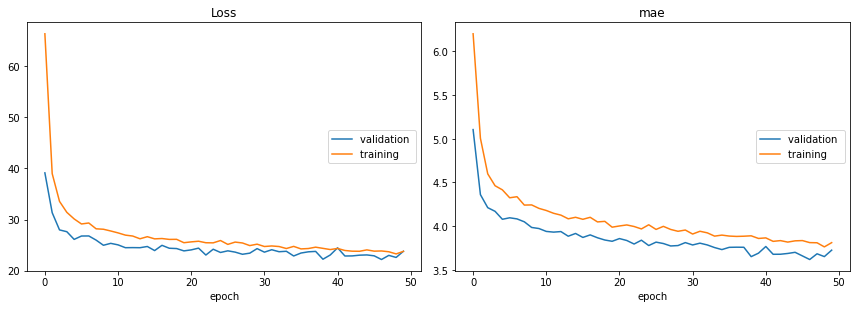

Loss
	validation       	 (min:   22.173, max:   39.130, cur:   23.794)
	training         	 (min:   23.267, max:   66.350, cur:   23.772)
mae
	validation       	 (min:    3.618, max:    5.106, cur:    3.725)
	training         	 (min:    3.763, max:    6.202, cur:    3.811)


In [60]:
h = model.fit(x_train,y_train,
            validation_data=(x_val,y_val),
            epochs=50,
            batch_size=128,
            callbacks = [PlotLossesKeras()])

In [61]:
from sklearn.metrics import mean_squared_error

In [167]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [168]:
reg = RandomForestRegressor()
reg.fit(x_train,y_train)

RandomForestRegressor()

In [169]:
y_pred = reg.predict(x_val)

In [172]:
y_pred = reg.predict(x_val)
print(np.sqrt(mean_squared_error(mm.inverse_transform(y_pred.reshape(-1,1)),mm.inverse_transform(y_val))))

3.986833213316576


In [173]:
y_test = reg.predict(x_test)
y_test = mm.inverse_transform(y_test.reshape(-1,1))
y_test = np.squeeze(y_test)
sub = pd.DataFrame({'tumor_size':y_test})
sub.to_csv("Submission.csv",index=False)